In [1]:
import os
import glob
import itertools
import copy
import sys
sys.path.insert(1, '/home/fpei2/learning/ttrnn/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

from ttrnn.trainer import A2C
from ttrnn.tasks.harlow import HarlowMinimal, Harlow1D, HarlowMinimalDelay
from neurogym.wrappers import PassAction, PassReward, Noise
from ttrnn.tasks.wrappers import DiscreteToBoxWrapper, RingToBoxWrapper, ParallelEnvs

In [3]:
ckpt_path = '/home/fpei2/learning/harlow_analysis/runs/harlowdelay3_gru256/epoch=19999-step=20000-v1.ckpt'

In [4]:
model_weights = torch.load(ckpt_path)['state_dict']
readout_weights = model_weights['model.actor.logits_net.weight'].detach().cpu().numpy()
readout_bias = model_weights['model.actor.logits_net.bias'].detach().cpu().numpy()
input_weights = model_weights['model.rnn.rnn_cell.weights.weight_ih'].detach().cpu().numpy()
rec_weights = model_weights['model.rnn.rnn_cell.weights.weight_hh'].detach().cpu().numpy()
rec_bias = model_weights['model.rnn.rnn_cell.weights.bias_hh'].detach().cpu().numpy()
del model_weights

In [5]:
task = HarlowMinimalDelay(
    dt=100,
    obj_dim=5,
    obj_mode="kb", 
    obj_init="normal",
    orthogonalize=True,
    abort=True,
    rewards={'abort': -0.1, 'correct': 1.0, 'fail': 0.0},
    timing={'fixation': 200, 'stimulus': 400, 'delay': 200, 'decision': 200},
    num_trials_before_reset=6,
    r_tmax=-1.0,
)

std_noise = 0.1
wrappers = [
    (Noise, {'std_noise': std_noise}),
    (PassAction, {'one_hot': True}), 
    (PassReward, {}), 
    (ParallelEnvs, {'num_envs': 8}),
]

if len(wrappers) > 0:
    for wrapper, wrapper_kwargs in wrappers:
        task = wrapper(task, **wrapper_kwargs)

### Load checkpoint

pl_module = A2C.load_from_checkpoint(ckpt_path, env=task)

model = pl_module.model
hx = model.rnn.build_initial_state(1, pl_module.device, pl_module.dtype)

In [5]:
### Load trajectory samples

template_path = "/home/fpei2/learning/harlow_analysis/runs/harlowdelay3_gru256/trajectories/epoch19999-v1_sample_multi*.npz"

file_paths = sorted(glob.glob(template_path))

states_list = []
condition_list = []
obj_list = []
for file_path in file_paths:
    trajectories = np.load(file_path)
    states_list.append(trajectories['states'])
    condition_list.append(trajectories['condition'])
    obj_list.append((trajectories['obj1'], trajectories['obj2']))

In [6]:
states = np.stack(states_list) # objset x cond x trial x time x dim
conditions = np.stack(condition_list) # objset x cond x feat
feat_names = [
    'objset', # (arbitrary) index of set of objects used as stimulus
    'reward_idx', # which object is rewarded
    'obj_left_1', # which object presented on left in first trial
    'choice', # which object was chosen in first trial,
    'obj_left_2', # which object presented on left in second trial
]

print(conditions[0, :2, :])

[[0 0 0 0 0]
 [0 0 0 0 1]]


In [7]:
# Center data

# states shape = objset x condition x trial x time x dim

all_mean = states.mean(axis=(0,1,2,3), keepdims=True) # mean channel value
states_c = states - all_mean # centered data

In [8]:
# compute ground-truth choice / fixation axes

fix_axis = readout_weights[0]
left_axis = readout_weights[1]
right_axis = readout_weights[2]

def ortho(u, v):
    return u, (v - np.dot(u, v) / np.dot(u, u) * u)

_, left_axis_o = ortho(fix_axis, left_axis)
_, right_axis_o = ortho(fix_axis, right_axis)

left_right_angle = np.arccos(np.dot(left_axis_o, right_axis_o) / (np.linalg.norm(left_axis_o) * np.linalg.norm(right_axis_o)))

fix_left_basis = np.stack([fix_axis, left_axis]).T # N x 2
fix_left_proj = np.linalg.inv(fix_left_basis.T @ fix_left_basis) @ (fix_left_basis.T @ right_axis_o[:, None])
right_residual = right_axis_o - (fix_left_basis @ fix_left_proj).squeeze()
right_plane_angle = np.arcsin(np.linalg.norm(right_residual) / np.linalg.norm(right_axis_o))
print(left_right_angle, right_plane_angle)

choice_axis = right_axis_o - left_axis_o

fix_axis /= np.linalg.norm(fix_axis)
choice_axis /= np.linalg.norm(choice_axis)

2.6307955 0.51079726


In [9]:
# just separate out all conditions ig

time_mean = states_c.mean(axis=(0,1,2), keepdims=True)
states_residual = states_c - time_mean

condition_means = states_c.mean(axis=2)

condition_means_stacked = condition_means.reshape(-1, condition_means.shape[-1])

pca_allcond = PCA()
allcond_pca = pca_allcond.fit_transform(condition_means_stacked)

max_dim = min(allcond_pca.shape[0], condition_means.shape[-1])
condition_means_pca = allcond_pca.reshape(condition_means.shape[:-1] + (max_dim,))

print(np.cumsum(pca_allcond.explained_variance_ratio_)[:8])

[0.33988363 0.46330935 0.5810503  0.6681544  0.72578466 0.77137154
 0.8094479  0.8446894 ]


In [10]:
# compute and project readout axes onto PCs

weight_mag = np.sum(readout_weights * readout_weights, axis=1)
zero_point = (-readout_bias / weight_mag)[:, None] * readout_weights - np.squeeze(all_mean)
end_point = zero_point + (5 * readout_weights / np.linalg.norm(readout_weights, axis=1)[:, None])

readout_weights_pca = pca_allcond.transform(readout_weights)
zero_point_pca = pca_allcond.transform(zero_point)
end_point_pca = pca_allcond.transform(end_point)

readout_plot_vec = np.stack([zero_point_pca, end_point_pca], axis=1)
# readout_plot_delta = readout_plot_vec[:, 1, :] - readout_plot_vec[:, 0, :]

In [12]:
states_c_flat = states_c.reshape(-1, states_c.shape[-1])
states_c_pca = pca_allcond.transform(states_c_flat).reshape(states_c.shape)

In [23]:
obj_grads = []

for objset in range(states.shape[0]):
    obj1, obj2 = obj_list[objset]

    obj1_left_grad = []
    obj2_left_grad = []

    for i, cond in enumerate(conditions[objset]):
        obj_left_1 = cond[2]
        obj_left_2 = cond[4]

        trial_1_stim = np.concatenate([
            np.array([1.]), 
            obj1 if obj_left_1 == 0 else obj2,
            obj2 if obj_left_1 == 0 else obj1,
            np.array([1., 0., 0., 0.]),
        ], axis=0)
        trial_2_stim = np.concatenate([
            np.array([1.]), 
            obj1 if obj_left_2 == 0 else obj2,
            obj2 if obj_left_2 == 0 else obj1,
            np.array([1., 0., 0., 0.]),
        ], axis=0)

        for trial_ix in range(states[objset][i].shape[0]):
            trial_states = states[objset][i][trial_ix]
            trial_states = interp1d(np.arange(18), trial_states, axis=0, kind='cubic')(np.arange(0, 17.5, 0.5))
            stim1 = trial_states[4:10]
            stim2 = trial_states[22:30]
            # delay = np.concat([trial_states[6:8], trial_states[15:17]], axis=0)

            for stim_state in stim1:
                next_state = model.rnn.rnn_cell(
                    torch.from_numpy(trial_1_stim[None, :]).to(pl_module.dtype),
                    torch.from_numpy(stim_state[None, :]).to(pl_module.dtype), 
                    cached=True
                ).detach().cpu().numpy()
                state_diff = next_state.squeeze() - stim_state
                if obj_left_1 == 0:
                    obj1_left_grad.append((stim_state, state_diff))
                else:
                    obj2_left_grad.append((stim_state, state_diff))
            
            for stim_state in stim2:
                next_state = model.rnn.rnn_cell(
                    torch.from_numpy(trial_2_stim[None, :]).to(pl_module.dtype),
                    torch.from_numpy(stim_state[None, :]).to(pl_module.dtype), 
                    cached=True
                ).detach().cpu().numpy()
                state_diff = next_state.squeeze() - stim_state
                if obj_left_2 == 0:
                    obj1_left_grad.append((stim_state, state_diff))
                else:
                    obj2_left_grad.append((stim_state, state_diff))
            
            # for delay_state in delay:
            #     next_state = model.rnn.rnn_cell(
            #         torch.from_numpy(delay_stim[None, :]).to(pl_module.dtype),
            #         torch.from_numpy(delay_state[None, :]).to(pl_module.dtype), 
            #         cached=True
            #     ).detach().cpu().numpy()
            #     state_diff = next_state.squeeze() - delay_state
            #     delay_grad.append((delay_state, state_diff))
    
    obj1_left_states, obj1_left_deltas = zip(*obj1_left_grad)
    obj1_left_states = np.stack(obj1_left_states)
    obj1_left_deltas = np.stack(obj1_left_deltas)

    obj2_left_states, obj2_left_deltas = zip(*obj2_left_grad)
    obj2_left_states = np.stack(obj2_left_states)
    obj2_left_deltas = np.stack(obj2_left_deltas)
    obj_grads.append((obj1_left_states, obj1_left_deltas, obj2_left_states, obj2_left_deltas))

In [11]:
states_c_upsamp = interp1d(np.arange(18), states_c, axis=3, kind='cubic')(np.arange(0, 17.5, 0.5))

In [31]:
objset = 0

obj_left_1_mask = (conditions[objset][:, 2] == 0)
obj_left_2_mask = (conditions[objset][:, 4] == 0)

obj1_left_states = np.concatenate([
    states_c_upsamp[objset][obj_left_1_mask][:, :, 4:12, :],
    states_c_upsamp[objset][obj_left_2_mask][:, :, 22:30, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj2_left_states = np.concatenate([
    states_c_upsamp[objset][~obj_left_1_mask][:, :, 4:12, :],
    states_c_upsamp[objset][~obj_left_2_mask][:, :, 22:30, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj1_left_next = np.concatenate([
    states_c_upsamp[objset][obj_left_1_mask][:, :, 5:13, :],
    states_c_upsamp[objset][obj_left_2_mask][:, :, 23:31, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj2_left_next = np.concatenate([
    states_c_upsamp[objset][~obj_left_1_mask][:, :, 5:13, :],
    states_c_upsamp[objset][~obj_left_2_mask][:, :, 23:31, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj1_left_states_pca = pca_allcond.transform(obj1_left_states)
obj1_left_next_pca = pca_allcond.transform(obj1_left_next)
obj2_left_states_pca = pca_allcond.transform(obj2_left_states)
obj2_left_next_pca = pca_allcond.transform(obj2_left_next)

In [35]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df_o1l = {
    'x': obj1_left_states_pca[:, 0],
    'y': obj1_left_states_pca[:, 1],
    'z': obj1_left_states_pca[:, 2],
    'u': (obj1_left_next_pca[:, 0] - obj1_left_states_pca[:, 0]),
    'v': (obj1_left_next_pca[:, 1] - obj1_left_states_pca[:, 1]),
    'w': (obj1_left_next_pca[:, 2] - obj1_left_states_pca[:, 2]),
    'grp': ['o1l'] * obj1_left_states_pca.shape[0],
}
df_o1l = pd.DataFrame(df_o1l)

df_o2l = {
    'x': obj2_left_states_pca[:, 0],
    'y': obj2_left_states_pca[:, 1],
    'z': obj2_left_states_pca[:, 2],
    'u': obj2_left_next_pca[:, 0] - obj2_left_states_pca[:, 0],
    'v': obj2_left_next_pca[:, 1] - obj2_left_states_pca[:, 1],
    'w': obj2_left_next_pca[:, 2] - obj2_left_states_pca[:, 2],
    'grp': ['o2l'] * obj1_left_states_pca.shape[0],
}
df_o2l = pd.DataFrame(df_o2l)

df = pd.concat([df_o1l, df_o2l], axis=0)

data_o1l = go.Cone(x=df_o1l['x'], y=df_o1l['y'], z=df_o1l['z'], u=df_o1l['u'], v=df_o1l['v'], w=df_o1l['w'], 
    sizemode='absolute', colorscale='Blues')
data_o2l = go.Cone(x=df_o2l['x'], y=df_o2l['y'], z=df_o2l['z'], u=df_o2l['u'], v=df_o2l['v'], w=df_o2l['w'], 
    sizemode='absolute', colorscale='Reds')
fig = go.Figure()
fig.add_trace(data_o1l)
fig.add_trace(data_o2l)

In [36]:
# project onto fixation and choice axes (and then PCA for the rest)

condition_means = states_c.mean(axis=2)

proj_fix_choice = np.stack([fix_axis, choice_axis]).T
condition_proj_means = condition_means @ proj_fix_choice
condition_ext_means = condition_means - condition_proj_means @ proj_fix_choice.T

condition_ext_means_stacked = condition_ext_means.reshape(-1, condition_ext_means.shape[-1])

pca_ext = PCA(n_components=(condition_ext_means_stacked.shape[-1] - 2))
ext_pca = pca_ext.fit_transform(condition_ext_means_stacked)

max_dim = min(ext_pca.shape[0], condition_ext_means.shape[-1] - 2)
condition_ext_means_pca = ext_pca.reshape(condition_ext_means.shape[:-1] + (max_dim,))
condition_ext_means_pca = np.concatenate([condition_proj_means, condition_ext_means_pca], axis=-1)

print(np.cumsum(pca_ext.explained_variance_ratio_)[:8])

[0.3549459  0.48609278 0.6022408  0.6944847  0.7465111  0.7873732
 0.8264228  0.8486684 ]


In [37]:
def fix_choice_pca_transform(arr):
    assert arr.shape[-1] == 256
    proj = arr @ proj_fix_choice
    ext = arr - proj @ proj_fix_choice.T
    ext = pca_ext.transform(ext)
    return np.concatenate([proj, ext], axis=-1)

obj1_left_states_fc = fix_choice_pca_transform(obj1_left_states)
obj1_left_next_fc = fix_choice_pca_transform(obj1_left_next)
obj2_left_states_fc = fix_choice_pca_transform(obj2_left_states)
obj2_left_next_fc = fix_choice_pca_transform(obj2_left_next)

In [39]:
df_o1l = {
    'x': obj1_left_states_fc[:, 1],
    'y': obj1_left_states_fc[:, 2] / 2,
    'z': obj1_left_states_fc[:, 3] / 2,
    'u': obj1_left_next_fc[:, 1] - obj1_left_states_fc[:, 1],
    'v': (obj1_left_next_fc[:, 2] - obj1_left_states_fc[:, 2]) / 2,
    'w': (obj1_left_next_fc[:, 3] - obj1_left_states_fc[:, 3]) / 2,
    'grp': ['o1l'] * obj1_left_states_fc.shape[0],
}
df_o1l = pd.DataFrame(df_o1l)

df_o2l = {
    'x': obj2_left_states_fc[:, 1],
    'y': obj2_left_states_fc[:, 2] / 2,
    'z': obj2_left_states_fc[:, 3] / 2,
    'u': obj2_left_next_fc[:, 1] - obj2_left_states_fc[:, 1],
    'v': (obj2_left_next_fc[:, 2] - obj2_left_states_fc[:, 2]) / 2,
    'w': (obj2_left_next_fc[:, 3] - obj2_left_states_fc[:, 3]) / 2,
    'grp': ['o2l'] * obj2_left_states_fc.shape[0],
}
df_o2l = pd.DataFrame(df_o2l)

data_o1l = go.Cone(x=df_o1l['x'], y=df_o1l['y'], z=df_o1l['z'], u=df_o1l['u'], v=df_o1l['v'], w=df_o1l['w'], 
    sizemode='absolute', colorscale='Blues')
data_o2l = go.Cone(x=df_o2l['x'], y=df_o2l['y'], z=df_o2l['z'], u=df_o2l['u'], v=df_o2l['v'], w=df_o2l['w'], 
    sizemode='absolute', colorscale='Reds')
fig = go.Figure()
fig.add_trace(data_o1l)
fig.add_trace(data_o2l)

In [47]:
objset = 3

obj_left_1_mask = (conditions[objset][:, 2] == 0)
obj_left_2_mask = (conditions[objset][:, 4] == 0)

obj1_left_states = np.concatenate([
    states_c_upsamp[objset][obj_left_1_mask][:, :, 4:12, :],
    states_c_upsamp[objset][obj_left_2_mask][:, :, 22:30, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj2_left_states = np.concatenate([
    states_c_upsamp[objset][~obj_left_1_mask][:, :, 4:12, :],
    states_c_upsamp[objset][~obj_left_2_mask][:, :, 22:30, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj1_left_next = np.concatenate([
    states_c_upsamp[objset][obj_left_1_mask][:, :, 5:13, :],
    states_c_upsamp[objset][obj_left_2_mask][:, :, 23:31, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj2_left_next = np.concatenate([
    states_c_upsamp[objset][~obj_left_1_mask][:, :, 5:13, :],
    states_c_upsamp[objset][~obj_left_2_mask][:, :, 23:31, :],
], axis=2).reshape(-1, states_c_upsamp.shape[-1])

obj1_left_states_pca = pca_allcond.transform(obj1_left_states)
obj1_left_next_pca = pca_allcond.transform(obj1_left_next)
obj2_left_states_pca = pca_allcond.transform(obj2_left_states)
obj2_left_next_pca = pca_allcond.transform(obj2_left_next)

In [48]:
def fix_choice_pca_transform(arr):
    assert arr.shape[-1] == 256
    proj = arr @ proj_fix_choice
    ext = arr - proj @ proj_fix_choice.T
    ext = pca_ext.transform(ext)
    return np.concatenate([proj, ext], axis=-1)

obj1_left_states_fc = fix_choice_pca_transform(obj1_left_states)
obj1_left_next_fc = fix_choice_pca_transform(obj1_left_next)
obj2_left_states_fc = fix_choice_pca_transform(obj2_left_states)
obj2_left_next_fc = fix_choice_pca_transform(obj2_left_next)

In [49]:
df_o1l = {
    'x': obj1_left_states_fc[:, 1],
    'y': obj1_left_states_fc[:, 2] / 2,
    'z': obj1_left_states_fc[:, 3] / 2,
    'u': obj1_left_next_fc[:, 1] - obj1_left_states_fc[:, 1],
    'v': (obj1_left_next_fc[:, 2] - obj1_left_states_fc[:, 2]) / 2,
    'w': (obj1_left_next_fc[:, 3] - obj1_left_states_fc[:, 3]) / 2,
    'grp': ['o1l'] * obj1_left_states_fc.shape[0],
}
df_o1l = pd.DataFrame(df_o1l)

df_o2l = {
    'x': obj2_left_states_fc[:, 1],
    'y': obj2_left_states_fc[:, 2] / 2,
    'z': obj2_left_states_fc[:, 3] / 2,
    'u': obj2_left_next_fc[:, 1] - obj2_left_states_fc[:, 1],
    'v': (obj2_left_next_fc[:, 2] - obj2_left_states_fc[:, 2]) / 2,
    'w': (obj2_left_next_fc[:, 3] - obj2_left_states_fc[:, 3]) / 2,
    'grp': ['o2l'] * obj2_left_states_fc.shape[0],
}
df_o2l = pd.DataFrame(df_o2l)

data_o1l = go.Cone(x=df_o1l['x'], y=df_o1l['y'], z=df_o1l['z'], u=df_o1l['u'], v=df_o1l['v'], w=df_o1l['w'], 
    sizemode='absolute', colorscale='Blues')
data_o2l = go.Cone(x=df_o2l['x'], y=df_o2l['y'], z=df_o2l['z'], u=df_o2l['u'], v=df_o2l['v'], w=df_o2l['w'], 
    sizemode='absolute', colorscale='Reds')
fig = go.Figure()
fig.add_trace(data_o1l)
fig.add_trace(data_o2l)

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
condition_means_tsne = tsne.fit_transform(condition_means_stacked).reshape(condition_means.shape[:-1] + (3,))

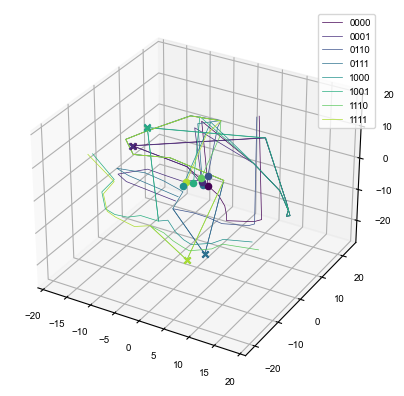

In [57]:
objset = 0

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, feats in enumerate(conditions[objset]):
    feat_name = ''.join([str(fn) for fn in feats])[1:]
    color = plt.get_cmap('viridis')(i / len(conditions[objset]))
    ax.plot(condition_means_tsne[objset][i][:, 0], condition_means_tsne[objset][i][:, 1], 
        condition_means_tsne[objset][i][:, 2], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_means_tsne[objset][i][0, 0], condition_means_tsne[objset][i][0, 1], 
        condition_means_tsne[objset][i][0, 2], marker='o', color=color)
    ax.scatter(condition_means_tsne[objset][i][9, 0], condition_means_tsne[objset][i][9, 1], 
        condition_means_tsne[objset][i][9, 2], marker='x', color=color)
plt.legend()